In [17]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, TreeSearch, BDeuScore, MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination



In [2]:
df = pd.read_csv("../data/heart.csv")


In [3]:
#df.sample(5)
#df.info()
#df.isnull().sum()
#print("Number of duplicates: " + str(df.duplicated().sum())) # There are 214 duplicate data, but we will not exclude them as they may be from different patients
#df.iloc[:, :-1].describe().T.sort_values(by='std' , ascending = False)
#df.describe(include=['O'])
df.columns

data = df.copy()

data.sample(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
784,65,M,TA,138,282,1,LVH,174,N,1.4,Flat,1
586,53,M,ASY,124,243,0,Normal,122,Y,2.0,Flat,1
28,53,F,ATA,113,468,0,Normal,127,N,0.0,Up,0
47,50,M,ATA,140,216,0,Normal,170,N,0.0,Up,0
312,41,M,ASY,125,0,1,Normal,176,N,1.6,Up,1


In [4]:
# Converting object columns to numeric - "LabelEncoder"

col = list(data.columns)
categorical_features = []
numerical_features = []
for i in col:
    if len(data[i].unique()) > 6:
        numerical_features.append(i)
    else:
        categorical_features.append(i)

print('Categorical Features :',*categorical_features)
print('Numerical Features :',*numerical_features)


# instanciar encoder
lb = LabelEncoder()

objList = data.select_dtypes(include = "object").columns

for obj in objList:
    # Stampo i valori unici prima dell'encoding
    print(f"\n===== Colonna: {obj} =====")
    print("PRIMA dell'encoding:")
    unique_values = data[obj].unique()
    print(unique_values)

    
    data[obj] = lb.fit_transform(data[obj].astype(str))

    # Stampo il mapping tra valori originali e valori codificati
    print("\nMAPPING dell'encoding:")
    for i, original_value in enumerate(lb.classes_):
        encoded_value = lb.transform([original_value])[0]
        print(f"'{original_value}' → {encoded_value}")
    
    # Stampo i valori unici dopo l'encoding
    print("\nDOPO l'encoding:")
    print(data[obj].unique())
    
    print("=" * 40)

data.sample(5)

Categorical Features : Sex ChestPainType FastingBS RestingECG ExerciseAngina ST_Slope HeartDisease
Numerical Features : Age RestingBP Cholesterol MaxHR Oldpeak

===== Colonna: Sex =====
PRIMA dell'encoding:
['M' 'F']

MAPPING dell'encoding:
'F' → 0
'M' → 1

DOPO l'encoding:
[1 0]

===== Colonna: ChestPainType =====
PRIMA dell'encoding:
['ATA' 'NAP' 'ASY' 'TA']

MAPPING dell'encoding:
'ASY' → 0
'ATA' → 1
'NAP' → 2
'TA' → 3

DOPO l'encoding:
[1 2 0 3]

===== Colonna: RestingECG =====
PRIMA dell'encoding:
['Normal' 'ST' 'LVH']

MAPPING dell'encoding:
'LVH' → 0
'Normal' → 1
'ST' → 2

DOPO l'encoding:
[1 2 0]

===== Colonna: ExerciseAngina =====
PRIMA dell'encoding:
['N' 'Y']

MAPPING dell'encoding:
'N' → 0
'Y' → 1

DOPO l'encoding:
[0 1]

===== Colonna: ST_Slope =====
PRIMA dell'encoding:
['Up' 'Flat' 'Down']

MAPPING dell'encoding:
'Down' → 0
'Flat' → 1
'Up' → 2

DOPO l'encoding:
[2 1 0]


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
473,60,1,2,141,316,1,2,122,1,1.7,1,1
255,53,0,2,120,274,0,1,130,0,0.0,2,0
246,54,1,2,120,237,0,1,150,1,1.5,1,1
106,48,0,0,120,254,0,2,110,0,0.0,2,0
488,65,1,3,140,252,0,1,135,0,0.3,2,0


In [5]:
# Converting numeric columns to bins
labels = [0, 1, 2]

# --- 1. Categorize Age ---
age_bins = [-float('inf'), 44, 60, float('inf')] 

data['Age_Category'] = pd.cut(data['Age'], bins=age_bins, labels=labels, right=True)

print(data[['Age', 'Age_Category']].head())
print("- " * 20)

# --- 2. Categorize RestingBP ---
bp_bins = [-np.inf, 119, 139, np.inf] # Bins for <120, 120-139, >=140

data['RestingBP_Category'] = pd.cut(data['RestingBP'], bins=bp_bins, labels=labels, right=True)

print(data[['RestingBP', 'RestingBP_Category']].head())
print("- " * 20)

# --- 3. Categorize Cholesterol ---
chol_bins = [-1, 0, 199, 239, np.inf] # Bins for 0, 1-199, 200-239, >=240
chol_labels = [0, 1, 2, 3]

data['Cholesterol_Category'] = pd.cut(data['Cholesterol'].fillna(-1), bins=chol_bins, labels=chol_labels, right=True)
print(data[['Cholesterol', 'Cholesterol_Category']].head())
print("- " * 20)

# --- 4. Categorize MaxHR ---
data['MaxHR_Category'] = pd.qcut(data['MaxHR'], q=3, labels=labels, duplicates='drop')

print(data[['MaxHR', 'MaxHR_Category']].head())
print("- " * 20)

# --- 5. Categorize Oldpeak ---
oldpeak_bins = [-np.inf, 0.99, 2.5, np.inf] # Bins for <1.0, 1.0-2.5, >2.5

data['Oldpeak_Category'] = pd.cut(data['Oldpeak'], bins=oldpeak_bins, labels=labels, right=True)

print(data[['Oldpeak', 'Oldpeak_Category']].head())

data.drop(numerical_features, axis=1, inplace=True)
print(data.columns)

   Age Age_Category
0   40            0
1   49            1
2   37            0
3   48            1
4   54            1
- - - - - - - - - - - - - - - - - - - - 
   RestingBP RestingBP_Category
0        140                  2
1        160                  2
2        130                  1
3        138                  1
4        150                  2
- - - - - - - - - - - - - - - - - - - - 
   Cholesterol Cholesterol_Category
0          289                    3
1          180                    1
2          283                    3
3          214                    2
4          195                    1
- - - - - - - - - - - - - - - - - - - - 
   MaxHR MaxHR_Category
0    172              2
1    156              2
2     98              0
3    108              0
4    122              0
- - - - - - - - - - - - - - - - - - - - 
   Oldpeak Oldpeak_Category
0      0.0                0
1      1.0                1
2      0.0                0
3      1.5                1
4      0.0              

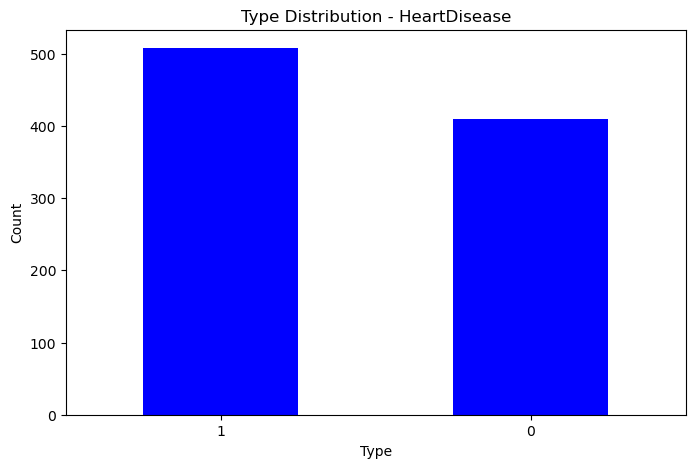

In [6]:
type_counts = data['HeartDisease'].value_counts()

# Create a bar plot for the type distribution
plt.figure(figsize=(8, 5))
type_counts.plot(kind='bar', color='blue')
plt.title('Type Distribution - HeartDisease')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [7]:
hd_corr = data.corr()["HeartDisease"].sort_values(ascending=False)
print(hd_corr)
#[1: heart disease, 0: Normal]

HeartDisease            1.000000
ExerciseAngina          0.494282
Oldpeak_Category        0.423730
Sex                     0.305445
FastingBS               0.267291
Age_Category            0.263913
RestingBP_Category      0.077988
RestingECG              0.057384
Cholesterol_Category   -0.192774
ChestPainType          -0.386828
MaxHR_Category         -0.399085
ST_Slope               -0.558771
Name: HeartDisease, dtype: float64


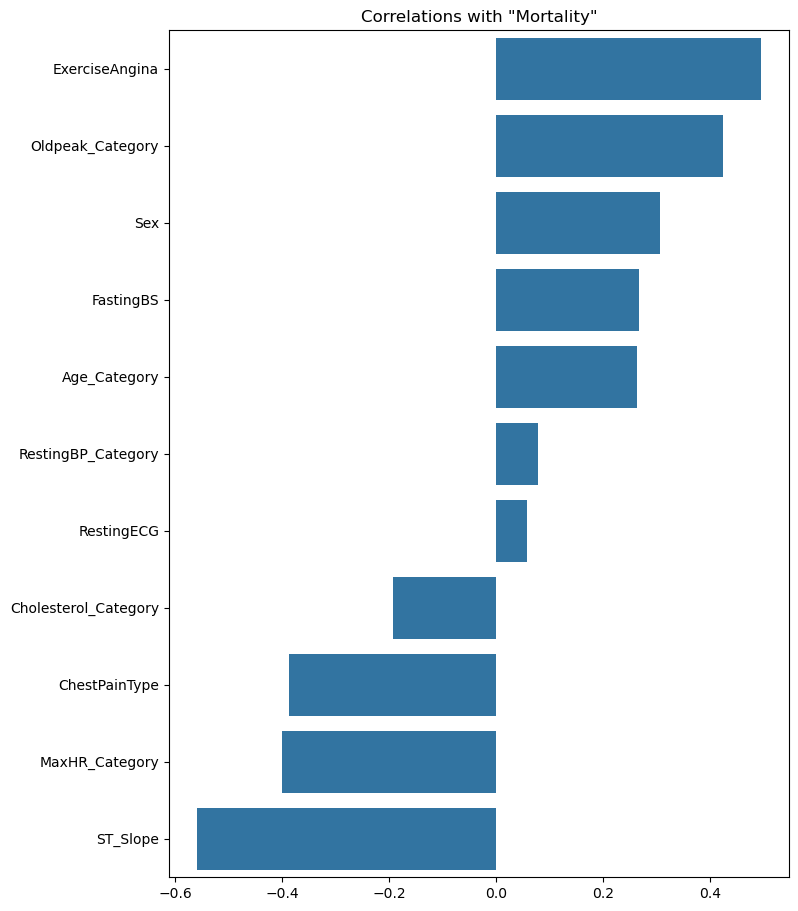

In [8]:
# Correlations with "Status"

limit = -1.0

indices = hd_corr.index
labels = []
corr = []
for i in range(1, len(indices)):
    if hd_corr[indices[i]]>limit:
        labels.append(indices[i])
        corr.append(hd_corr[i])


fig, ax = plt.subplots(figsize=(8,11))
sns.barplot(x=corr, y=labels, ax=ax)
plt.title('Correlations with "Mortality"')
plt.show()


Graph saved successfully as custom_bn.png


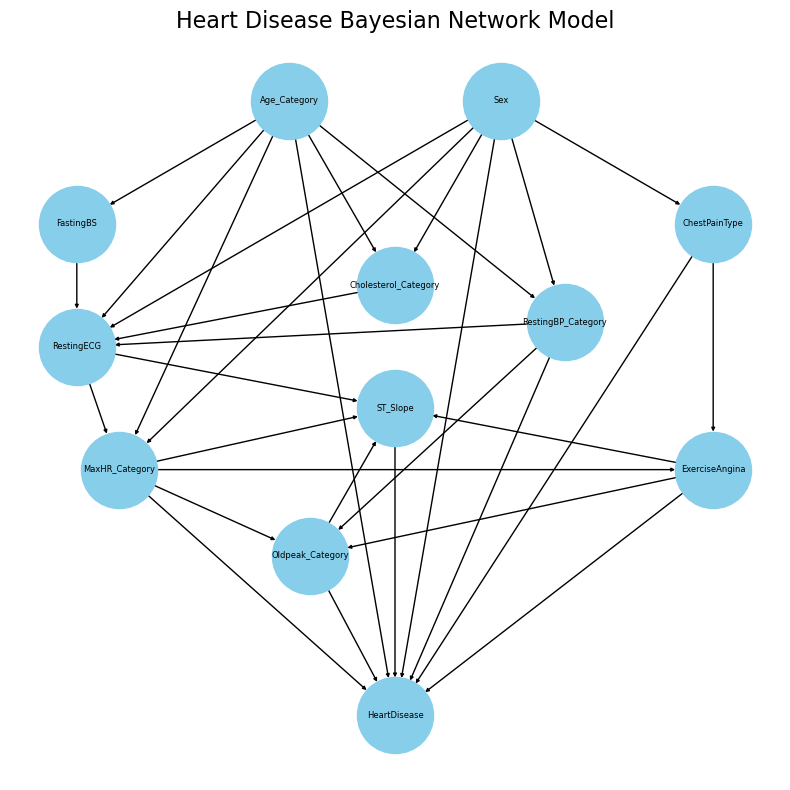

In [9]:
# Define the Bayesian Network structure (same as before)
heart_disease_model = BayesianNetwork([
    ('Age_Category', 'RestingBP_Category'), ('Age_Category', 'Cholesterol_Category'), ('Age_Category', 'MaxHR_Category'),
    ('Age_Category', 'RestingECG'), ('Age_Category', 'FastingBS'), ('Age_Category', 'HeartDisease'), 
    ('Sex', 'Cholesterol_Category'),('Sex', 'MaxHR_Category'), ('Sex', 'RestingECG'),  ('Sex', 'RestingBP_Category'), ('Sex', 'ChestPainType'), ('Sex', 'HeartDisease'),
    ('FastingBS', 'RestingECG'),
    ('Cholesterol_Category', 'RestingECG'),
    ('RestingBP_Category', 'RestingECG'), ('RestingBP_Category', 'Oldpeak_Category'), ('RestingBP_Category', 'HeartDisease'),
    ('RestingECG', 'ST_Slope'), ('RestingECG', 'MaxHR_Category'),
    ('MaxHR_Category', 'ST_Slope'), ('MaxHR_Category', 'ExerciseAngina'), ('MaxHR_Category', 'Oldpeak_Category'), ('MaxHR_Category', 'HeartDisease'), 
    ('ChestPainType', 'ExerciseAngina'), ('ChestPainType', 'HeartDisease'),
    ('ExerciseAngina', 'ST_Slope'), ('ExerciseAngina', 'Oldpeak_Category'), ('ExerciseAngina', 'HeartDisease'),
    ('Oldpeak_Category', 'ST_Slope'), ('Oldpeak_Category', 'HeartDisease'),
    ('ST_Slope', 'HeartDisease')
])

pos = {'Age_Category': [0.75, -0.5], 'Sex': [1.25, -0.5],
       'FastingBS': [0.25, -1.], 'Cholesterol_Category': [1., -1.25], 'ChestPainType': [1.75,  -1],
       'RestingBP_Category': [1.40, -1.40], 'RestingECG': [0.25, -1.5],
       'MaxHR_Category': [0.35,  -2],
       'ExerciseAngina': [1.75, -2], 'Oldpeak_Category': [0.80, -2.35], 'ST_Slope': [1.,  -1.75], 
       'HeartDisease': [1, -3]}

# --- Visualization ---
# Create a figure and axes for the plot
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Draw the network graph using a different layout
try:
    #pos = nx.kamada_kawai_layout(heart_disease_model)
    #pos = nx.circular_layout(heart_disease_model)
    #pos = nx.shell_layout(heart_disease_model)
    nx.draw_networkx(heart_disease_model, pos=pos, ax=ax, node_size=3000,
                     node_color='skyblue', font_size=6, arrows=True, arrowsize=5)

    # Set the title and save the figure
    ax.set_title('Heart Disease Bayesian Network Model', fontsize=16)
    plt.axis('off') # Turn off the axis box
    fig.tight_layout() # Adjust layout
    fig.savefig('custom_bn.png') # Saves the plot as a PNG file
    print("Graph saved successfully as custom_bn.png")
    # plt.show() # Uncomment to display if in an interactive environment

except Exception as e:
    print(f"An error occurred during graph layout or drawing: {e}")
    print("Consider trying a different layout algorithm or simplifying the graph if the issue persists.")

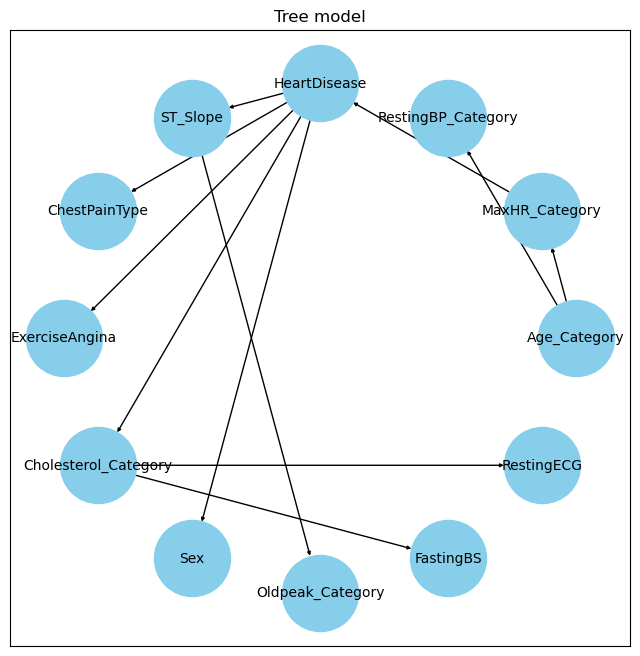

In [10]:
ts = TreeSearch(data=data, root_node='Age_Category' ) # Age_Category - Sex
tree_model = ts.estimate(show_progress=False)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
nx.draw_networkx(tree_model, pos=nx.drawing.layout.circular_layout(tree_model), ax=ax, node_size=3000,
                     node_color='skyblue', font_size=10, arrows=True, arrowsize=5)
fig.savefig('tree')
ax.set_title('Tree model')
tree_model = BayesianNetwork(tree_model.edges())

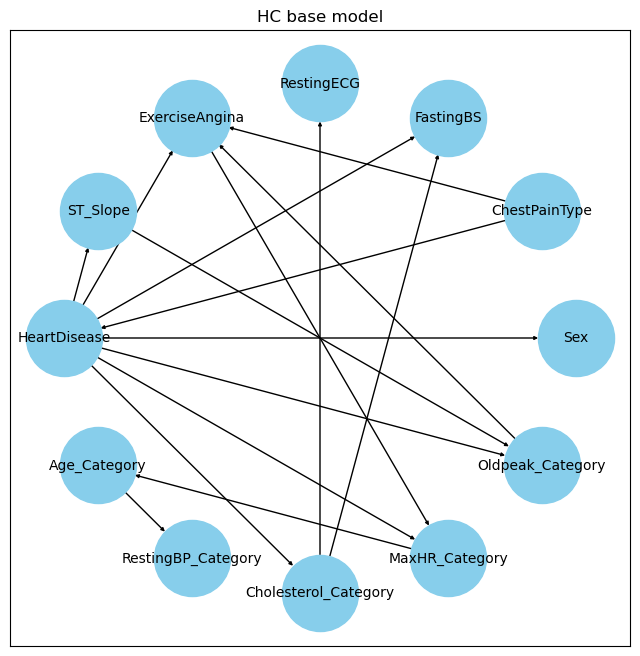

In [11]:
scorer = BDeuScore(data=data)
hc = HillClimbSearch(data=data)
hc_base_model = hc.estimate(scoring_method=scorer, show_progress=False)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
nx.draw_networkx(hc_base_model, pos=nx.drawing.layout.circular_layout(hc_base_model), ax=ax, node_size=3000,
                     node_color='skyblue', font_size=10, arrows=True, arrowsize=5)
fig.savefig('hc_base')
ax.set_title('HC base model')
hc_base_model = BayesianNetwork(hc_base_model.edges())

In [12]:
models = [('custom', heart_disease_model), ('tree', tree_model), 
          ('hc base', hc_base_model)]
for name, model in models:
    print(f'Computing CDTs for {name} model')
    model.fit(data, estimator=MaximumLikelihoodEstimator)

Computing CDTs for custom model
Computing CDTs for tree model
Computing CDTs for hc base model


In [14]:
data.columns

Index(['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina',
       'ST_Slope', 'HeartDisease', 'Age_Category', 'RestingBP_Category',
       'Cholesterol_Category', 'MaxHR_Category', 'Oldpeak_Category'],
      dtype='object')

In [16]:
nodes = ['Sex', 'Age_Category', 'FastingBS', 'MaxHR_Category', 'ST_Slope', 'Cholesterol_Category', 'HeartDisease']
print('Considering nodes:', nodes)
for name, model in models:
    print(f'Analyzing model: {name}')
    print(f'The total number of valid independence assertions is {len(model.get_independencies().get_assertions())}')
    print(f'Local semantics of the current model:\n{model.local_independencies(nodes)}')
    print('Checking Markov blankets')
    for node in nodes:
        print(f'The Markov blanket of node {node} is {model.get_markov_blanket(node)}')
    print()

Considering nodes: ['Sex', 'Age_Category', 'FastingBS', 'MaxHR_Category', 'ST_Slope', 'Cholesterol_Category', 'HeartDisease']
Analyzing model: custom
The total number of valid independence assertions is 2822
Local semantics of the current model:
(Sex ⟂ Age_Category, FastingBS)
(Age_Category ⟂ ChestPainType, Sex)
(FastingBS ⟂ Cholesterol_Category, ChestPainType, RestingBP_Category, Sex | Age_Category)
(MaxHR_Category ⟂ Cholesterol_Category, FastingBS, ChestPainType, RestingBP_Category | RestingECG, Age_Category, Sex)
(ST_Slope ⟂ Cholesterol_Category, ChestPainType, Age_Category, RestingBP_Category, FastingBS, Sex | RestingECG, Oldpeak_Category, ExerciseAngina, MaxHR_Category)
(Cholesterol_Category ⟂ ChestPainType, FastingBS, RestingBP_Category | Age_Category, Sex)
(HeartDisease ⟂ RestingECG, FastingBS, Cholesterol_Category | ST_Slope, Sex, ChestPainType, Age_Category, Oldpeak_Category, RestingBP_Category, MaxHR_Category, ExerciseAngina)
Checking Markov blankets
The Markov blanket of nod

In [18]:
inferences = [(name, VariableElimination(model)) for name, model in models]

In [49]:
values = [(2,2), (1,3), (1, 2), (0, 3), (0, 1)]
answer_values = {}
print(f"Scenarios: the following pairs of critic/user scores will be tested\n{values}")
for name, ve in inferences:
    print(f"Performing inference for model: {name}")
    answer_values[name] = {}
    for age, chest_pain_type in values:
        evidence = {"Age_Category": age, "ChestPainType": chest_pain_type}
        answer_values[name][(age, chest_pain_type)] = ve.query(["HeartDisease"], evidence, show_progress=False).values


Scenarios: the following pairs of critic/user scores will be tested
[(2, 2), (1, 3), (1, 2), (0, 3), (0, 1)]
Performing inference for model: custom
Performing inference for model: tree
Performing inference for model: hc base


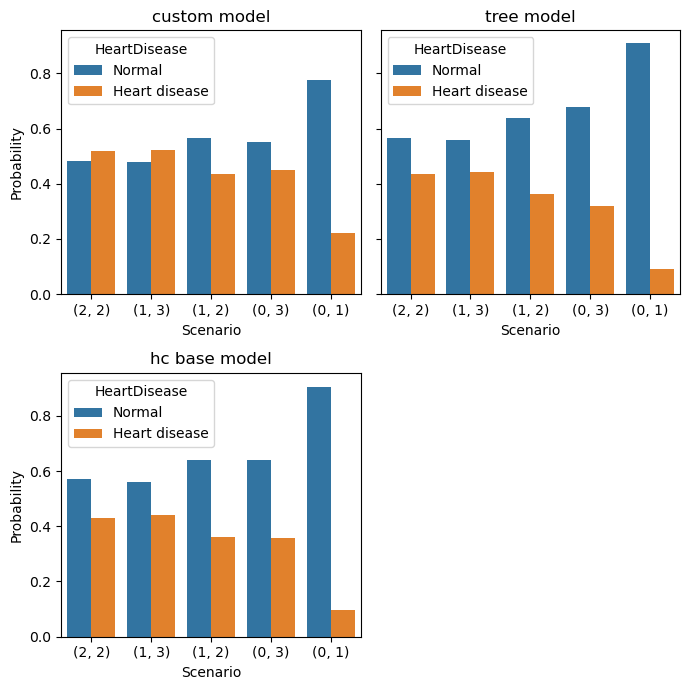

In [56]:
num_models = len(answer_values)
ncols = int(np.ceil(np.sqrt(num_models)))
nrows = int(np.ceil(num_models / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(3.5 * ncols, 3.5 * nrows), sharey=True, squeeze=False)
axes = axes.flatten() 

model_index = 0 # To keep track of which axis to use
for model_name, scenario_results in answer_values.items():
    ax = axes[model_index] # Get the current subplot axis
    ax.set_title(f"{model_name} model")

    plot_data_list = []
    for scenario_tuple, probability_array in scenario_results.items():
        for heart_disease_state, probability in enumerate(probability_array):
            plot_data_list.append([
                str(scenario_tuple),        
                heart_disease_state,       
                probability                
            ])

    # Create the DataFrame
    probs_df = pd.DataFrame(
        plot_data_list,
        columns=['Scenario', 'HeartDisease', 'Probability'] 
    )

    heart_disease_map = {0: 'Normal', 1: 'Heart disease'}
    probs_df['HeartDisease'] = probs_df['HeartDisease'].map(heart_disease_map)

    # Create the bar plot on the current axis
    sns.barplot(x='Scenario', y="Probability", hue="HeartDisease", data=probs_df, ax=ax)


    model_index += 1 # Move to the next axis index

# 4. Hide any unused subplots (if grid is larger than models)
for i in range(model_index, len(axes)):
    axes[i].set_visible(False)

# 5. Adjust layout and display the plot
plt.tight_layout() # Adjust spacing between subplots
plt.show()

Which Chest pain type cause a high risk of Heart disease in an male Adult patient?

In [61]:
pain_types = [0, 1, 2, 3] # [ASY: 0, ATA: 1, NAP: 2, TA: 3]
answer_pain_typess = {}
evidence = {"Age_Category": 2, "Sex": 1}
print(f"Scenario: Chest pain type of an old male man")
print(f"Possible pain type: {pain_types}")
for name, ve in inferences:
    answer_pain_typess[name] = {}
    print(f"Performing inference for model: {name}")
    for pain_type in pain_types:
        evidence['ChestPainType'] = pain_type
        answer_pain_typess[name][pain_type] = ve.query(["HeartDisease"], evidence, show_progress=False).values


Scenario: Chest pain type of an old male man
Possible pain type: [0, 1, 2, 3]
Performing inference for model: custom
Performing inference for model: tree
Performing inference for model: hc base


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15), sharey=True)
axes = axes.flatten()
for ax, name in zip(axes, answer_pain_typess):
    ax.set_title(f"{name} model")
    probs = pd.DataFrame([[plat, int(sales), float(prob)] 
                          for plat in answer_pain_typess[name]
                          for sales, prob in enumerate(answer_pain_typess[name][plat])], 
                         columns=['Platform', 'Global Sales', 'Probability'])
    sns.barplot(x="Platform", y="Probability", hue="Global Sales", data=probs, ax=ax)
fig.savefig('query2')